In [115]:
# Import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

# Hide warnings in the notebook
from warnings import filterwarnings
filterwarnings('ignore')

In [116]:
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

In [117]:
# Set plots properties
sns.set_style('darkgrid')

In [118]:
# Dataset url
file_url = 'https://raw.githubusercontent.com/faadeola/credit-risk-ml-prediction/refs/heads/main/credit_risk_dataset.csv'

# Read dataset for analysis
credit = pd.read_csv(file_url)

# Actual column names
feature_desc_mapping = {
    'person_age' : 'Age',
    'person_income' : 'Annual Income',
    'person_home_ownership' : 'Home Ownership',
    'person_emp_length' : 'Employment Length (in years)',
    'loan_intent' : 'Loan Intent',
    'loan_grade' : 'Loan Grade',
    'loan_amnt' : 'Loan Amount',
    'loan_int_rate' : 'Interest Rate (%)',
    'loan_status' : 'Loan Status',
    'loan_percent_income' : 'Percent Income',
    'cb_person_default_on_file' : 'Historical Default',
    'cb_person_cred_hist_length' : 'Credit History Length'
    }

In [119]:
#vShow 10 random rows in the dataset
credit.sample(frac=0.15)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
22113,29,37000,RENT,1.0,MEDICAL,B,6500,NaN,0,0.18,N,8
11129,25,72000,OWN,8.0,EDUCATION,A,18000,7.66,0,0.25,N,3
7931,22,55000,MORTGAGE,6.0,VENTURE,B,12000,9.99,0,0.22,N,4
23269,28,26000,RENT,2.0,DEBTCONSOLIDATION,A,5000,7.90,0,0.19,N,6
8057,22,49000,MORTGAGE,6.0,EDUCATION,A,10000,8.00,1,0.20,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
9480,23,62000,MORTGAGE,1.0,PERSONAL,B,6500,10.95,0,0.10,N,3
32064,38,30000,RENT,2.0,PERSONAL,C,2200,NaN,0,0.07,Y,15
21071,28,45000,MORTGAGE,2.0,EDUCATION,A,3000,5.79,0,0.07,N,8
3296,24,36000,MORTGAGE,8.0,PERSONAL,A,4800,6.91,0,0.13,N,3


# Exploratory Data Analysis and Feature Engineering
This section explores the data file further to understand the structure and distribution

In [120]:
# Shape of the dataset
print(f'Data has {credit.shape[0]} rows and {credit.shape[1]} columns')

Data has 32581 rows and 12 columns


In [121]:
# General overview of the dataset
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [122]:
# Display statistical information about the numerical columns
credit.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.73,6.35,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.85,61983.12,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.79,4.14,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.37,6322.09,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.01,3.24,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.17,0.11,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.80,4.06,2.00,3.00,4.00,8.00,30.00


In [123]:
# Check for duplicates in data
has_duplicates = credit.duplicated().sum()

print(f'{has_duplicates} duplicates found in the data')

# Drop duplicates if any
credit.drop_duplicates(keep='first', ignore_index=True, inplace=True)

165 duplicates found in the data


In [124]:
""" Group numerical and categorical data type"""
numerical_columns = credit.select_dtypes(include=['int64','float64']).drop(columns='loan_status') #For numerical data types
categorical_columns = credit.select_dtypes(include='object') #For categorical data types

In [125]:
# Get all unique values for categorical columns
for column in categorical_columns:
  print(f'{column}: {credit[column].unique()}')

person_home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade: ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file: ['Y' 'N']


In [126]:
# Checks for null values
credit.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,887
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3095
loan_status,0
loan_percent_income,0


In [127]:
""" Fill missing values in the order of Mode (categorical data) and Mean (Numerical data) """

#Fill categorical data
for column in categorical_columns:
    if credit[column].isnull().sum() > 0:
        credit[column] = credit[column].fillna(credit[column].mode())

# Fill numerical data
for column in numerical_columns:
    if credit[column].isnull().sum() > 0:
        credit[column] = credit[column].fillna(credit[column].mean())

In [128]:
# Check if null value still exists
credit.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0


In [129]:
credit['loan_intent'] = credit['loan_intent'].str.replace('DEBTCONSOLIDATION','Debt Consolidation').str.replace('HOMEIMPROVEMENT','Home Improvement')
credit['loan_intent'].value_counts()

,count
loan_intent,
EDUCATION,6411
MEDICAL,6042
VENTURE,5682
PERSONAL,5498
Debt Consolidation,5189
Home Improvement,3594


In [130]:
# Standardized values in the object columns to title case
for column in categorical_columns:
    credit[column] = credit[column].str.strip().str.title()

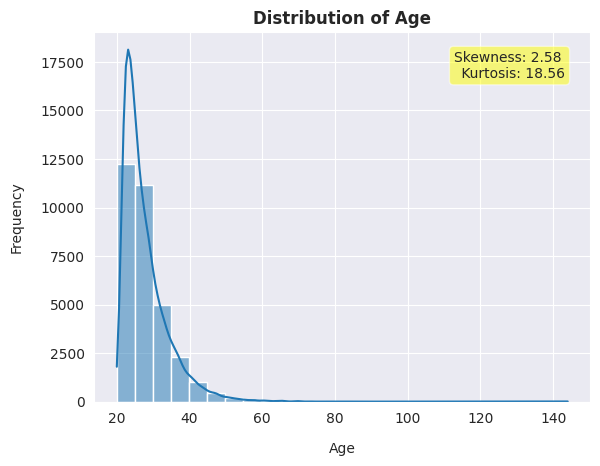

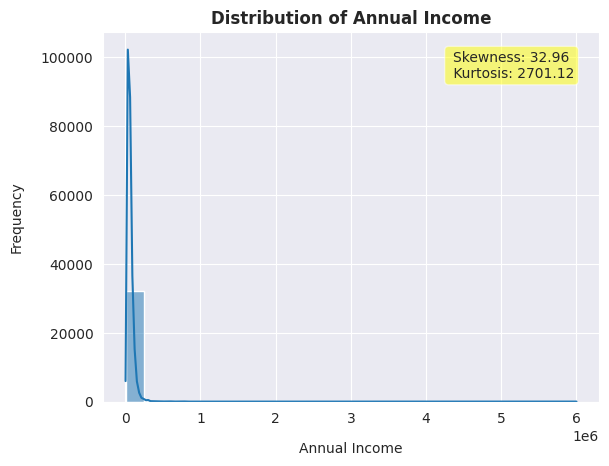

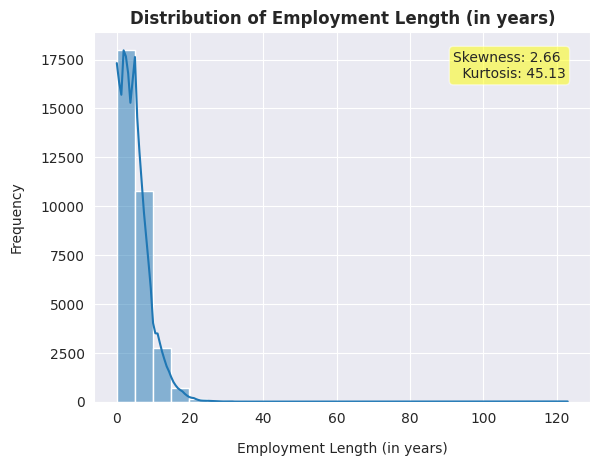

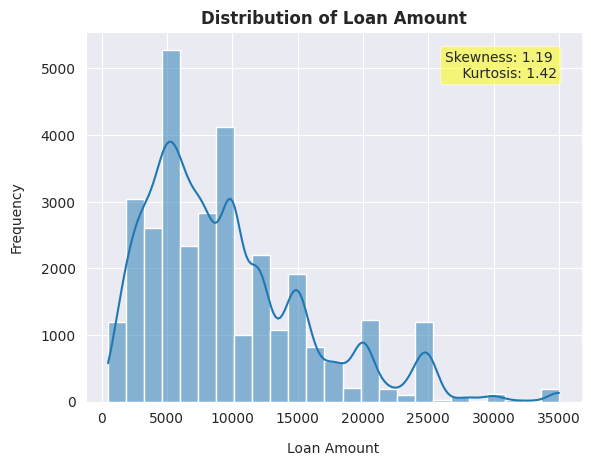

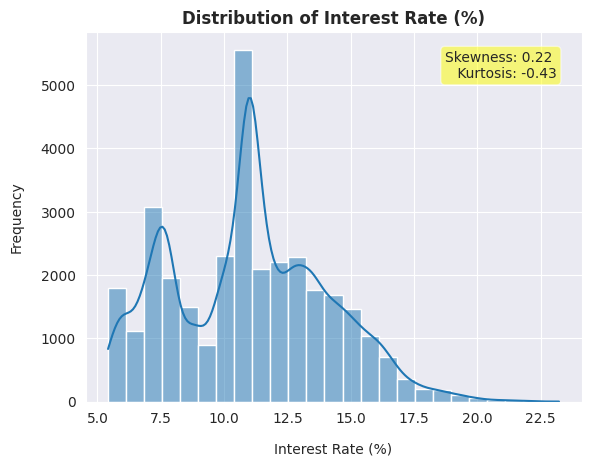

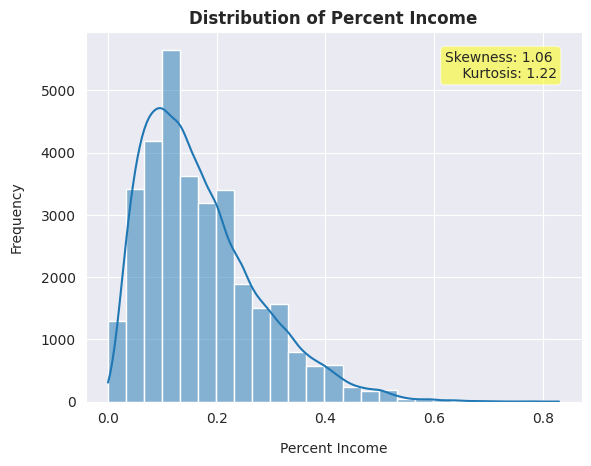

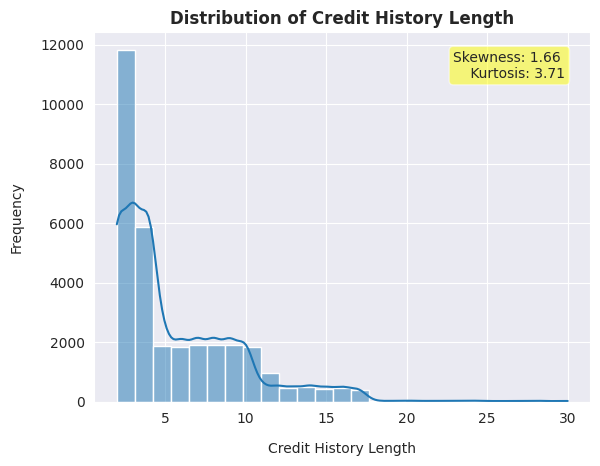

In [131]:
# Plot histogram of the numerical columns in the dataset to understand data distributions
for col in numerical_columns:
  fig, ax = plt.subplots()
  sns.histplot(credit[col],kde=True, bins=25)
  plt.title(f'Distribution of {feature_desc_mapping[col]}', fontweight='semibold')
  plt.text(0.95,0.95,f'Skewness: {credit[col].skew():.2f} \n Kurtosis: {credit[col].kurtosis():.2f}',transform = ax.transAxes, horizontalalignment = 'right', verticalalignment = 'top', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
  plt.xlabel(f'{feature_desc_mapping[col]}', labelpad=12)
  plt.ylabel('Frequency', labelpad=12)
  plt.show()

  # Print line break after each plot
  print('\n')

In [132]:
''' Check for outliers in the data'''

def get_outlier(column):
    # This function returns the outliers in a column

    Q1 = credit[column].quantile(0.25)
    Q3 = credit[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR) #--Get the lower bound values
    upper_bound = Q3 + (1.5 * IQR) #--Get the upper bound values

    outliers = ((credit[column] < lower_bound) | (credit[column] > upper_bound))

    return outliers, outliers.sum()

# Dictionary to hold outliers in each columns
outlier_dict = {}

# Get the number of outliers in each column
for col in numerical_columns.columns:
    col_outlier = get_outlier(col)[1] # Stores number of outlier in a column
    outlier_dict[col] = col_outlier # Add value and key to dictionary

# Display dictionary information as a DataFrame
outlier_df = pd.DataFrame({'Outlier Count': outlier_dict})
outlier_df.head()

,Outlier Count
person_age,1491
person_income,1478
person_emp_length,852
loan_amnt,1679
loan_int_rate,70


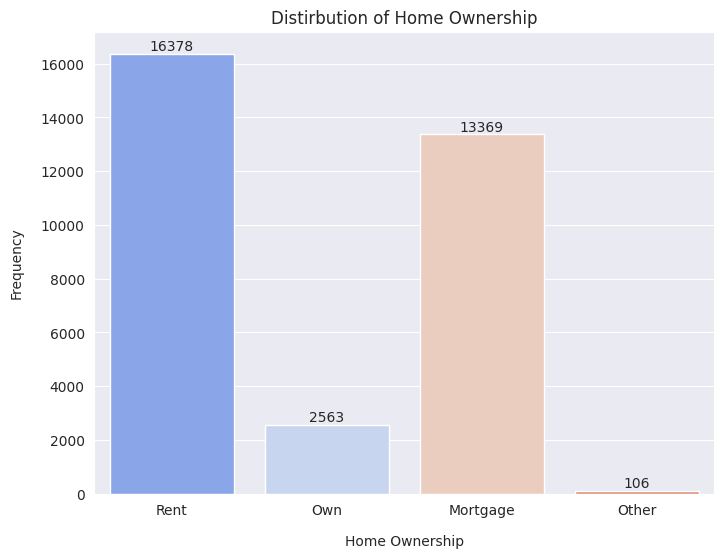

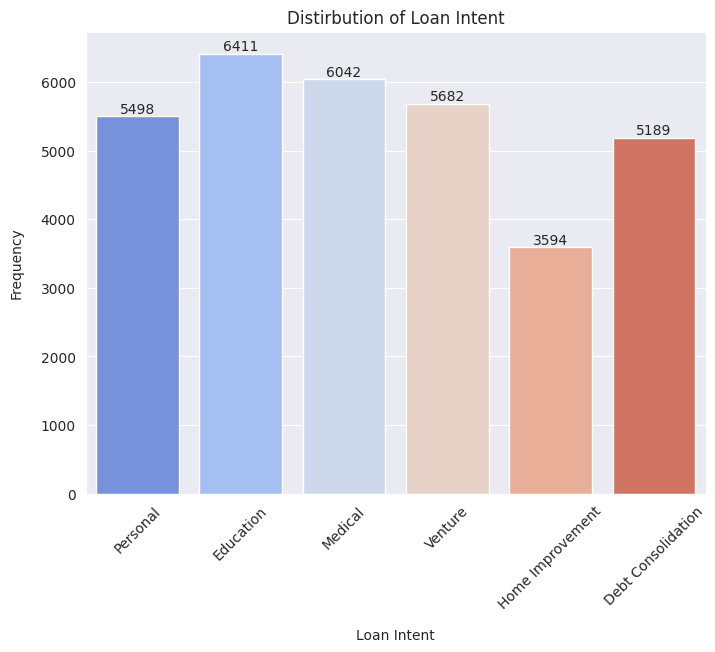

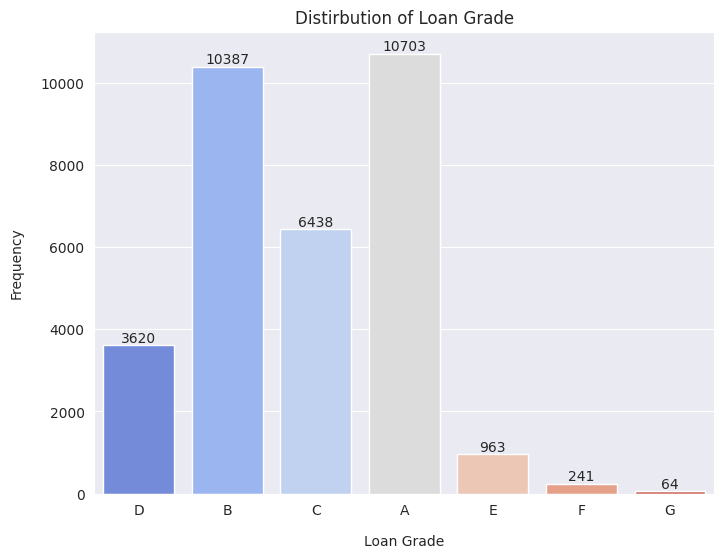

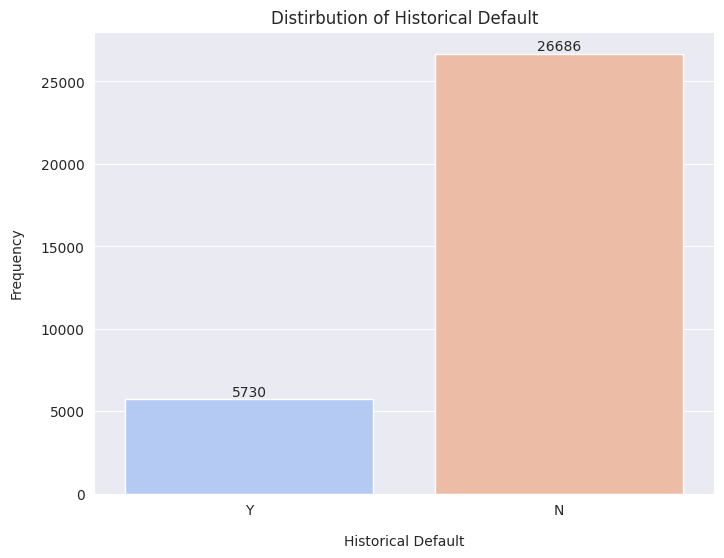

In [133]:
# Display count plot to understand distribution of categorical data
for col in categorical_columns.columns:
  fig,ax = plt.subplots(figsize=(8,6), dpi=100)
  sns.countplot(data=credit, x= f'{col}', palette='coolwarm', ax=ax)
  plt.title(f'Distirbution of {feature_desc_mapping[col]}')
  plt.xlabel(f'{feature_desc_mapping[col]}', labelpad=12)

  if col == 'loan_intent':
    plt.xticks(rotation=45)

  plt.ylabel('Frequency', labelpad=12)

  # Add count labels on top of each bar
  for container in ax.containers:
      ax.bar_label(container, fmt='%d', label_type='edge')

  plt.show()

  # Print line break after each plot
  print('\n')

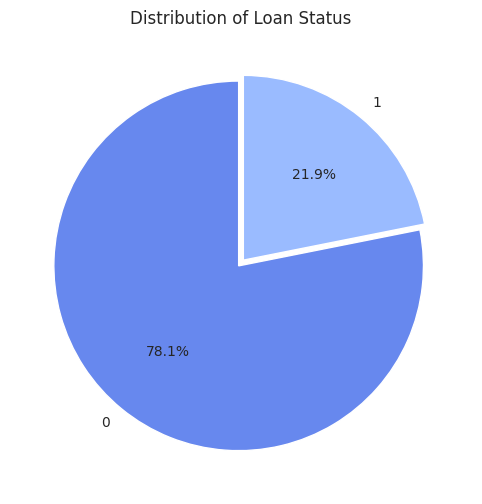

In [134]:
# Distribution of target feature
frequency = credit['loan_status'].value_counts()
fig,ax= plt.subplots(figsize=(8,6))
plt.pie(frequency.values, labels=frequency.index, autopct='%1.1f%%', startangle=90, explode=[0.02,0.02], colors=sns.color_palette('coolwarm'))
plt.title('Distribution of Loan Status')
plt.show()

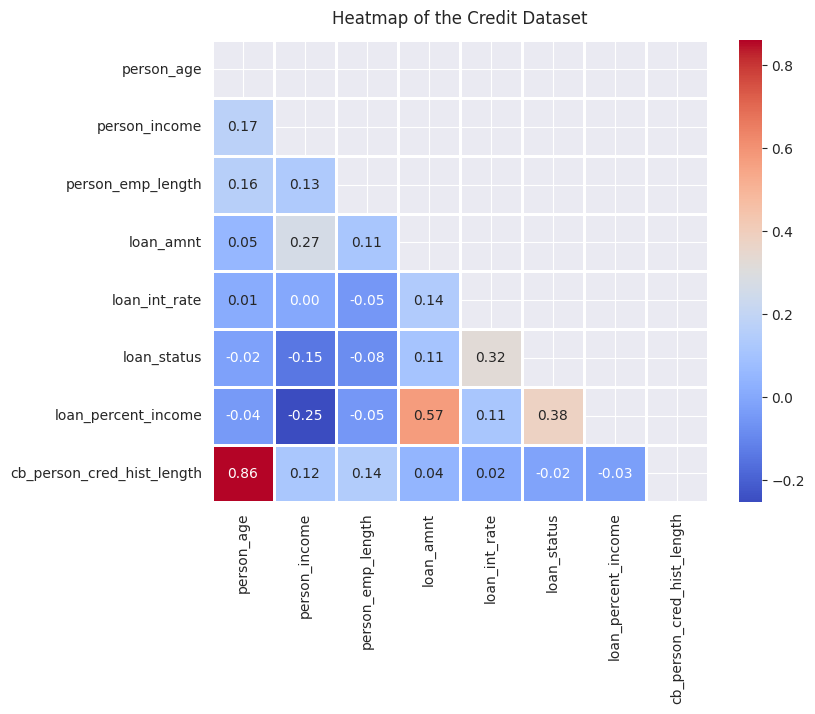

In [135]:
# Heat map of credit data
credit_corr = credit.corr(numeric_only=True)
mask = np.triu(np.ones_like(credit_corr))
plt.subplots(figsize=(8,6))
sns.heatmap(data=credit_corr, mask=mask, fmt='.2f', annot=True, cmap='coolwarm', linewidths=2, cbar=True)
plt.title('Heatmap of the Credit Dataset', pad=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [136]:
"""Classify person into age groups"""
# categorize age into groups
bin = [20,30,40,50,60,120]
age_label = ['20-30','31-40','41-50','51-60','60 and above']

# create group and add to daataset as a new column
credit['Age group'] = pd.cut(credit['person_age'],bins=bin, labels=age_label, right=True, include_lowest=True)

In [137]:
# Transform credit history to numerical column
credit['cb_person_default_on_file'] = np.where(credit['cb_person_default_on_file']=='Y',1,0).astype('int')

In [138]:
# Remove outliers across all numerical columns
def remove_outliers(numerical_cols):
    """
    Removes rows where numerical columns has an outlier.
    """
    row_mask = pd.Series(True, index=credit.index)

    for col in numerical_cols:
        col_outliers = get_outlier(col)[0]
        row_mask = row_mask & (~col_outliers)

    return credit[row_mask].copy()

# Assign clean data to initial dataframe name
credit = remove_outliers(numerical_columns)

In [139]:
# Check the new shape of the data
print(f'The dataframe now have {credit.shape[0]} rows and {credit.shape[1]} columns after removing outliers')

The dataframe now have 26833 rows and 13 columns after removing outliers


# Data Preprocessing
Preparation for model training

In [140]:
feature = credit.drop(columns='loan_status')
target = credit['loan_status']

"""Group data types"""
# Numerical columns
feature_num_columns = feature.select_dtypes(include=['int','float']).drop(columns='person_age',axis=1).columns

# Ordinal columns
feature_ord_columns = feature[['loan_grade']].columns

# Catgorical columns
feature_cat_columns = feature.select_dtypes(include=['object','category']).drop(columns='loan_grade',axis=1).columns

In [141]:
# Split columns for training and testing
X_train, x_test, Y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 42)

In [142]:
# Get shape of split data
print(f'X_train has {X_train.shape[0]} rows for training')
print(f'Y_train has {Y_train.shape[0]} rows for training')
print(f'X_test has {x_test.shape[0]} rows for testing')
print(f'Y_test has {y_test.shape[0]} rows for testing')

X_train has 21466 rows for training
Y_train has 21466 rows for training
X_test has 5367 rows for testing
Y_test has 5367 rows for testing


In [143]:
# Make column transformation
preprocessor = ColumnTransformer([
    ('scaler', RobustScaler(), feature_num_columns),
    ('lencoder', OrdinalEncoder(categories=[['G','F','E','D','C','B','A']]), feature_ord_columns),
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), feature_cat_columns)
    ], remainder= 'passthrough'
  )

# Baseline Model training






In [144]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', SMOTE()),
    ('model', RandomForestClassifier())
])

In [153]:
# Create dictionary to store models

models = {
    'rfc': {
        'name':'Random Forest Classifier',
        'model': RandomForestClassifier(random_state=42)
    },
    'dtc': {
        'name': 'Decision Tree Classifier',
        'model': DecisionTreeClassifier(random_state=42)
    },
    'xgb': {
        'name': 'XGBoost',
        'model': XGBClassifier(random_state=42)
    },
    'lgrc': {
        'name': 'Logistic Regression',
        'model': LogisticRegressionCV(random_state=42)
    },
    'svm': {
        'name': 'Support Vector Machine',
        'model': SVC(probability= True, random_state=42)
    }
}

----------------------------------------------------------------------------------------------------
--> Random Forest Classifier <--
----------------------------------------------------------------------------------------------------
Accuracy Score 0.927333705980995 

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      4266
           1       0.92      0.71      0.80      1101

    accuracy                           0.93      5367
   macro avg       0.92      0.85      0.88      5367
weighted avg       0.93      0.93      0.92      5367



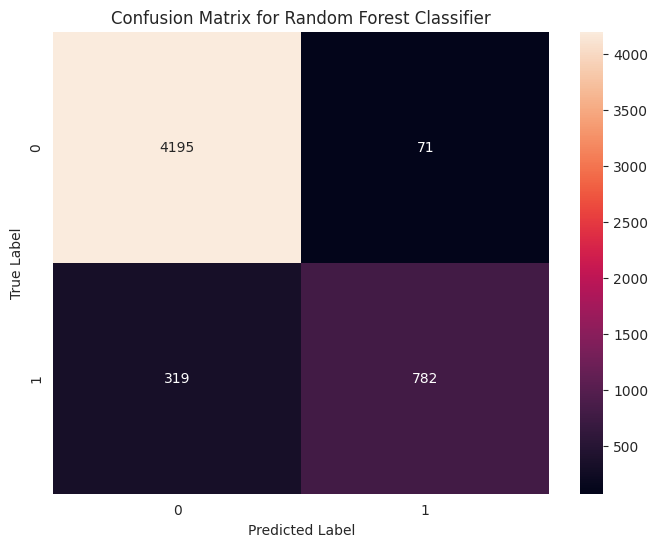

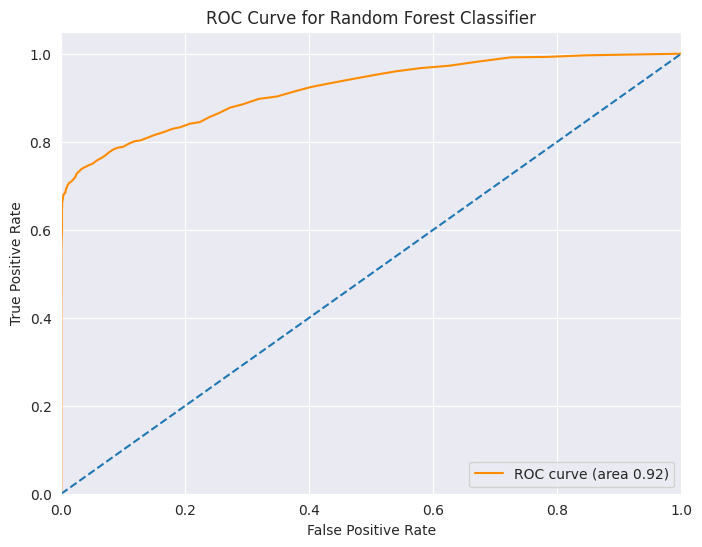




----------------------------------------------------------------------------------------------------
--> Decision Tree Classifier <--
----------------------------------------------------------------------------------------------------
Accuracy Score 0.8762809763368735 

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4266
           1       0.68      0.76      0.72      1101

    accuracy                           0.88      5367
   macro avg       0.81      0.83      0.82      5367
weighted avg       0.88      0.88      0.88      5367



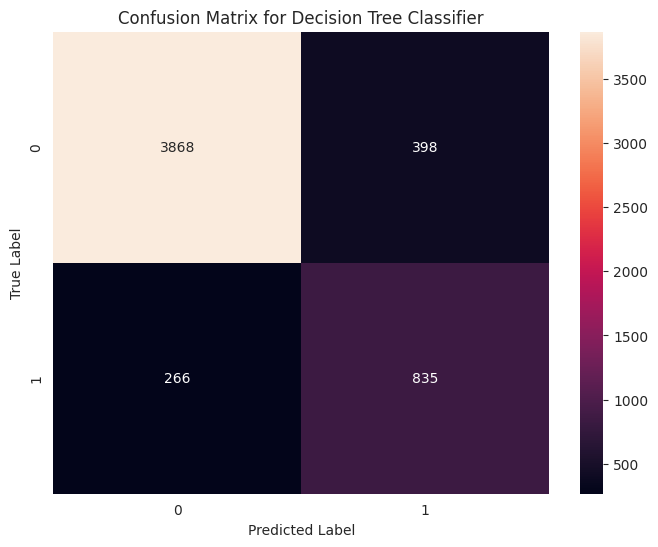

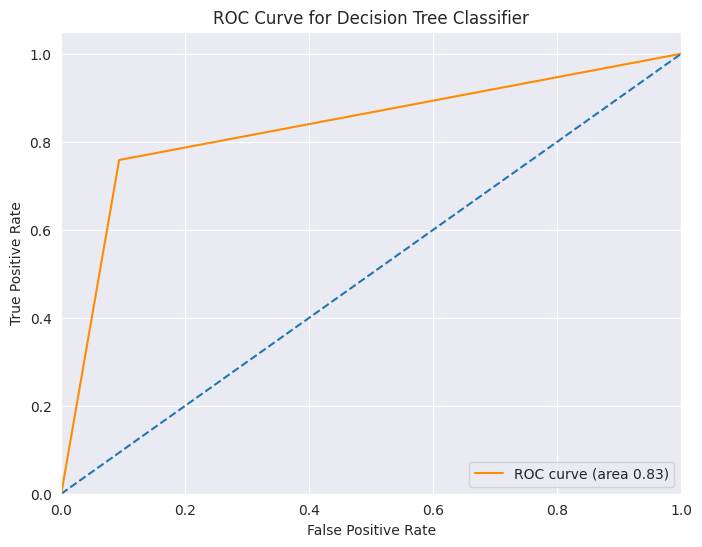




----------------------------------------------------------------------------------------------------
--> XGBoost <--
----------------------------------------------------------------------------------------------------
Accuracy Score 0.9340413638904416 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4266
           1       0.95      0.71      0.82      1101

    accuracy                           0.93      5367
   macro avg       0.94      0.85      0.89      5367
weighted avg       0.94      0.93      0.93      5367



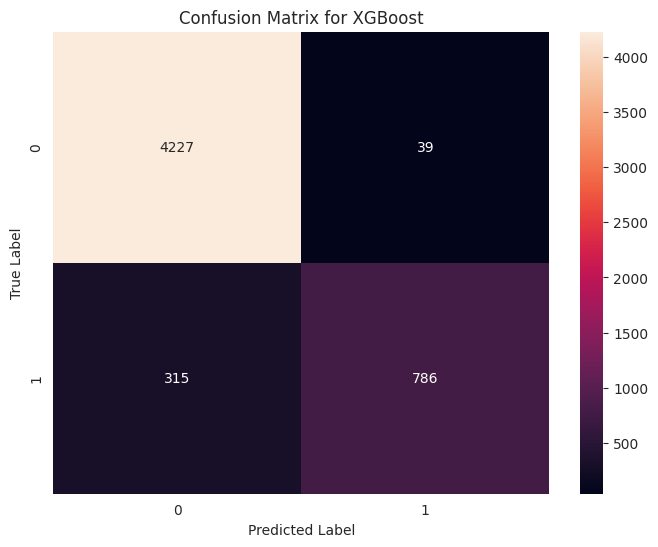

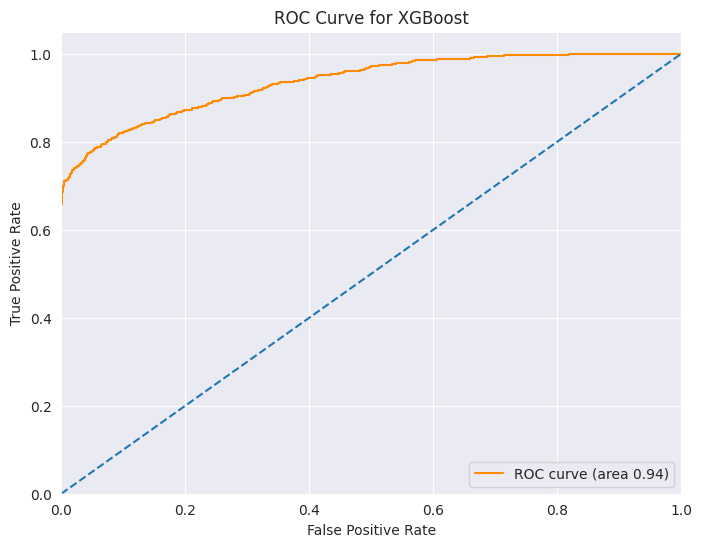




----------------------------------------------------------------------------------------------------
--> Logistic Regression <--
----------------------------------------------------------------------------------------------------
Accuracy Score 0.7810694987888951 

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4266
           1       0.48      0.77      0.59      1101

    accuracy                           0.78      5367
   macro avg       0.70      0.78      0.72      5367
weighted avg       0.84      0.78      0.80      5367



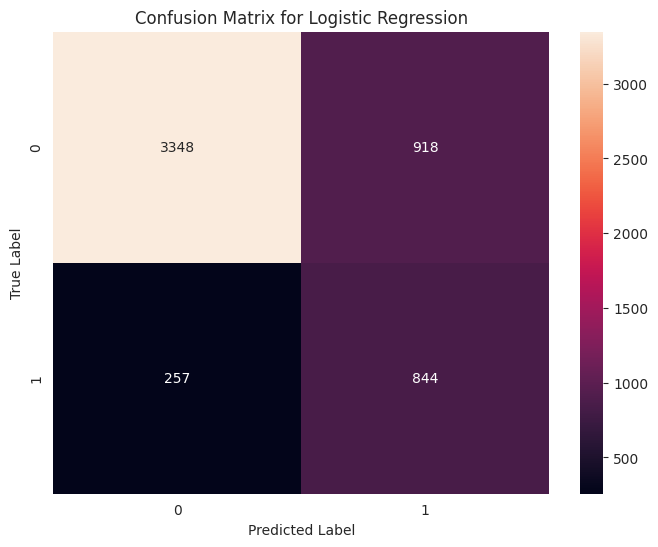

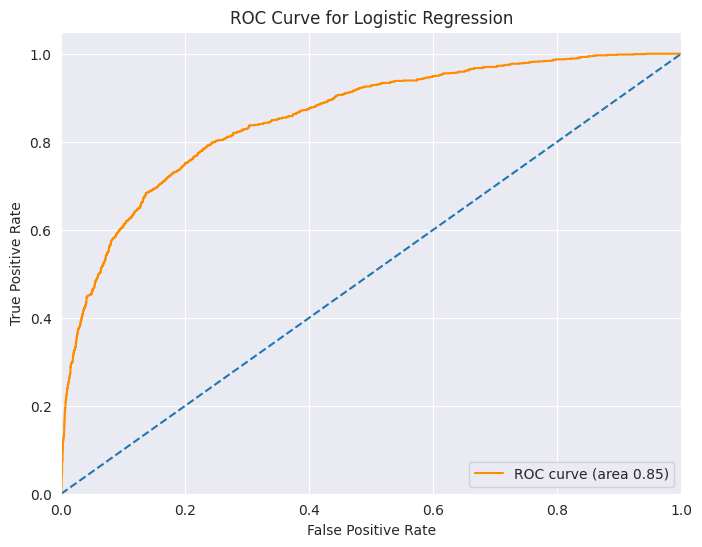




----------------------------------------------------------------------------------------------------
--> Support Vector Machine <--
----------------------------------------------------------------------------------------------------
Accuracy Score 0.7833053847587106 

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      4266
           1       0.48      0.78      0.59      1101

    accuracy                           0.78      5367
   macro avg       0.71      0.78      0.72      5367
weighted avg       0.84      0.78      0.80      5367



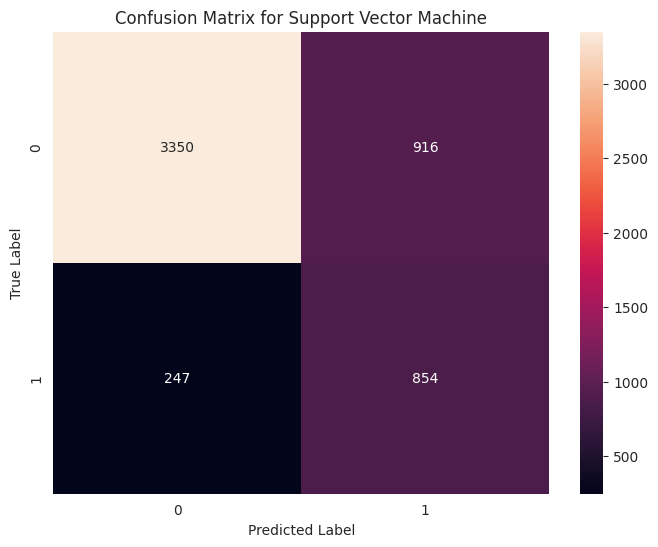

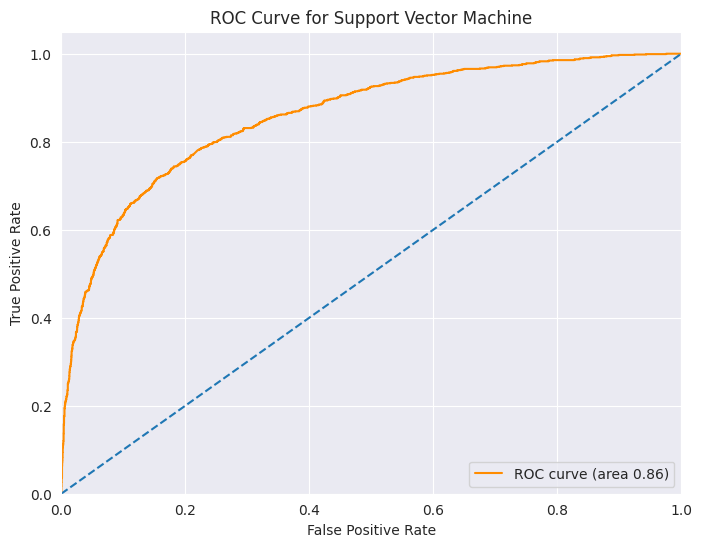

In [157]:
''' Training models by looping through the model dictionary while also outputing metrics'''

for abbr, model_dict in models.items():

  # Chnange the default model in the pipeline to the current running model
  pipeline.set_params(model = models[abbr]['model'])

  # Train model with split data
  pipeline.fit(X_train,Y_train)

  # Make prediction using
  y_pred = pipeline.predict(x_test)

  # Get metrics
  acc_score = accuracy_score(y_test,y_pred)
  class_report = classification_report(y_test,y_pred)
  cm = confusion_matrix(y_test,y_pred)

  # Show metrics
  print('-'*100)
  print(f'--> {models[abbr]['name']} <--')
  print('-'*100)

  print(f'Accuracy Score {acc_score} \n')
  print(class_report)

  # Plot the confusion matrix of the model
  plt.subplots(figsize=(8,6), dpi=100)
  sns.heatmap(cm,annot=True,fmt='d',cbar=True,)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'Confusion Matrix for {models[abbr]['name']}')
  plt.show()

  # Add line break
  print('\n\n')

  # Plot ROC curve of the current model
  y_proba = pipeline.predict_proba(x_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_proba)
  roc_auc = roc_auc_score(y_test, y_proba)

  plt.figure(figsize=(8, 6), dpi=100)
  plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {models[abbr]['name']}')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

  # Add line break
  print('\n\n')
